<a href="https://colab.research.google.com/github/williamkho-xzq/text-as-data/blob/main/Lab_1_Tokenization_and_Document_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text as Data Lab 1: Tokenization and Documentation Similarity

The goal of the first lab is to find Reddit posts that are similar to our post of interest and learn about the standard text processing pipeline along the way.

**Before you start, save a copy of this lab to your drive using "File > Save a Copy in Drive".** If you skip this step, you may lose the progress that you have made (e.g., if you close the browser tab or your computer crashes).

This lab is linked with the first lecture. Please refer to the slides as needed.

In this lab, you will learn about:
- Tokenizing, stemming and other steps of processing text
- Using Spacy for many of these steps
- Calculating document similarity


### Lab Code Testing

Throughout the lab, you will be asked to complete the code for functions (highlighted by **Exercise**). You can test your code using the `labtest` function, which is specific to the TextAsData labs. This provides a small number of testcases to check if your code seems to be doing the right thing. They are not exhaustive tests.

Before you can use it, you need to install it by running the next cell. This installs it from the [GitHub repo](https://github.com/jakelever/glasgowcs_labtest/) and loads the tests for this lab.



In [ ]:
# Installs the labtest system and loads the tests for this specific lab

!pip install -U git+https://github.com/jakelever/glasgowcs_labtest.git
from glasgowcs_labtest.textasdata.lab1 import labtest


Let's do a quick example of using the `labtest` function.

**Exercise:** Complete the `multiply_by_three` function below so that it returns `3*x`.

In [ ]:
def multiply_by_three(x):
  # your code!

# Example usage:
multiply_by_three(7)

Now run `labtest` with the function you want to test. `labtest` looks up the tests for that function and runs them. You'll get a (hopefully) useful error if your function doesn't match the expected test cases.

In [ ]:
labtest(multiply_by_three)

Try rewriting your multiply_by_three to do the wrong thing (like multiply by two) and rerun `labtest` above.

You can get more information about labtest, including the functions that it can test, by executing `?labtest`

In [ ]:
?labtest

We'll use the `labtest` function to check a few of the functions that you write in this lab.

### Reddit Data

In many of the labs, we will use data of posts from Reddit. This data was collected through the [Reddit API](https://www.reddit.com/dev/api/). Let's download it again (as we did in Lab 0) using wget. Recall that `!` at the beginning of a command tells Colab to run the command on the Linux system --- not in Python.

In [ ]:
!wget -O reddit_posts.json https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EY_R8Y7DkrxMqXGe-zlgeNkBdJU5ZNTf8FYrN2pqDwddMA?download=1

To load the file into Python, we need to use the JSON module as below. This loads it in a list of posts.

In [ ]:
import json
with open('reddit_posts.json') as f:
  posts = json.load(f)

Always good to check what you've loaded:

In [ ]:
print(type(posts))
print(len(posts))

And what does a single post look like?

In [ ]:
posts[0]

## The Similarity Problem

We want to be able to measure the similarity between Reddit posts so that we can find the most similar posts for a particular post of interest.

Here are the posts from the lecture: the post of interest and two options. Which one (A or B) do you think is closer to the post of interest?

In [ ]:
target_post = posts[0]
option_a = posts[1]
option_b = posts[2]

In [ ]:
print('TARGET:',target_post['title'])
print('-'*30)
print('A:', option_a['title'])
print('-'*30)
print('B:', option_b['title'])
print('-'*30)

## Building our own Text Pipeline

We need to tokenize and further process the text in these Reddit posts. We're going to go through each step to see what's involved.

### Tokenization

In class, we decided that the number of overlapping tokens (which are similar to words) would be a useful measure of similarity. But first, we need the words.

**Exercise:** Write a function (`tokenize_strsplit`) that splits text using whitespace. The [str.split](https://docs.python.org/3/library/stdtypes.html#str.split) function may be of help. The output for `tokenize_strsplit("I like irn bru")` should be `["I", "like", "irn", "bru"]`

In [ ]:
def tokenize_strsplit(text):
    # your code!

# Example usage:
tokenize_strsplit("The quick brown fox jumped over the lazy dog.")

Use the `labtest` function to check the code.

In [ ]:
labtest(tokenize_strsplit)

Let's try running it on a different sentence:

In [ ]:
print(tokenize_strsplit("Toto, I've got a feeling we're not in Kansas anymore."))

Not bad, but as we talked about in class, there are some issues with punctuation. Note how the comma is attached to "Toto" and the full stop to "anymore". That's not ideal.

Let's work on our own tokenizer so we can come up with custom rules. Here is a rule-based tokenizer that also splits using spaces. At the moment, it has a similar output as `tokenize_strsplit` above. Take a look to see how it works.

In [ ]:
import string

def tokenize_whitespace_rule(text):
  prev_c = ' ' # Keep track of the previous character (and set as a space initially)
  tokens = []

  # Loop through each character in the text
  for c in text:

    # Ignore characters that are whitespace (e.g. spaces, tabs, etc)
    if not c in string.whitespace:

      # If this is the start of a token (because the previous character is a space)
      if prev_c in string.whitespace:
        is_new_token = True
      else: # This is continuation of a token
        is_new_token = False

      if is_new_token:
        tokens.append(c)
      else: # If we're not adding a new token, add the character to the last token
        tokens[-1] += c

    prev_c = c # Track what the previous character is

  return tokens

# Example usage:
tokenize_whitespace_rule("The quick brown fox jumped over the lazy dog.")

We're going to extend the idea from `tokenize_basic` and add some extra rules to deal with things like punctuation.

Specifically, a new token should start when:
- Whitespace creates a new token
  - e.g. 'a word' -> ['a', 'word']
- There is a transition between letters (A-Z, a-z), numbers (0-9) or punctuation
  - e.g. 'abc123.#.abc' => ['abc', '123', '.#.', 'abc']

**Exercise:** Copy the code for `tokenize_whitespace_rule` above and modify it to create a function `tokenize_rulebased` below that splits on both whitespace and a change between letters, digits and punctuation.

The output of `tokenize_punctuation` for the input `"John's father didn't have $100."` should be `['John', "'", 's', 'father', 'didn', "'", 't', 'have', '$', '100', '.']`.

Using some of the constants in the [string](https://docs.python.org/3/library/string.html) module, you can check if a character is punctuation, digits or text. For example, `"m" in string.ascii_letters` is `true`, `"^" in string.punctuation` is `true` and `"7" in string.digits` is also true.

In [ ]:
def tokenize_rulebased(text):
  # your code!

# Example usage:
tokenize_rulebased("John's father didn't have $100.")

In [ ]:
labtest(tokenize_rulebased)

Great. You could now tokenize and split out punctuation and numbers. There are a lot more rules that we could implement. Things like splitting "don't" into "do" and "n't" are common. But we'll stop here with our `tokenize_rulebased` function.

### Stemming

Now, let's have a look at the next step, which is normalizing some of the words.

**Exercise:** Write a function (`stem_onerule`) that takes a list of tokens and trims off "ing" of any tokens that end with that suffix.

For an input of `["He", "is", "reading"]`, it should give an output of `["He", "is", "read"]`

In [ ]:
def stem_onerule(tokens):
  # your code!

stem_onerule(["I", "like", "walking", "."])

In [ ]:
labtest(stem_onerule)

Excellent. There are a lot of rules that can be implemented. The Porter Stemmer shown in class has a very long list of possible rules. We'll implement a couple more.

**Exercise:** Extend your function above with the stemming rules below and complete `stem_morerules`. Note that one of the rules is that the word "is" shouldn't be changed.

```
is -> is
(stem)ing -> stem
(stem)ed -> stem
(stem)s -> stem
```

In [ ]:
def stem_morerules(tokens):
  # your code!

# Example usage:
stem_morerules(['Yesterday', 'he', 'walked', 'to', 'the', 'shop', '.', 'Today,', 'he', 'is', 'walking', 'everywhere', '.'])

In [ ]:
labtest(stem_morerules)

### Text Case

Another small step often needed is converting all text to lowercase so that analyses become case-insensitive.

**Exercise:** Implement the `lowercase_tokens` function that takes in a list of tokens and returns their lowercase version.

In [ ]:
def lowercase_tokens(tokens):
  # your code!

# Example usage:
lowercase_tokens(['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '.'])

In [ ]:
labtest(lowercase_tokens)

### Stopwords Removal

We should also remove any common words from our list of tokens. There is no definitive list of stopwords. For now, we'll use the set proposed by C.J. Van Rijsbergen in his book Information Retrieval. The code below sets up the `stopwords` set.

In [ ]:
# Source is Table 2.1 of Chapter 2 of Information Retrieval by C.J. Van Rijsbergen
# http://www.dcs.gla.ac.uk/Keith/Chapter.2/Ch.2.html

stopword_text = """
A               CANNOT          INTO            OUR             THUS
ABOUT           CO              IS              OURS            TO
ABOVE           COULD           IT              OURSELVES       TOGETHER
ACROSS          DOWN            ITS             OUT             TOO
AFTER           DURING          ITSELF          OVER            TOWARD
AFTERWARDS      EACH            LAST            OWN             TOWARDS
AGAIN           EG              LATTER          PER             UNDER
AGAINST         EITHER          LATTERLY        PERHAPS         UNTIL
ALL             ELSE            LEAST           RATHER          UP
ALMOST          ELSEWHERE       LESS            SAME            UPON
ALONE           ENOUGH          LTD             SEEM            US
ALONG           ETC             MANY            SEEMED          VERY
ALREADY         EVEN            MAY             SEEMING         VIA
ALSO            EVER            ME              SEEMS           WAS
ALTHOUGH        EVERY           MEANWHILE       SEVERAL         WE
ALWAYS          EVERYONE        MIGHT           SHE             WELL
AMONG           EVERYTHING      MORE            SHOULD          WERE
AMONGST         EVERYWHERE      MOREOVER        SINCE           WHAT
AN              EXCEPT          MOST            SO              WHATEVER
AND             FEW             MOSTLY          SOME            WHEN
ANOTHER         FIRST           MUCH            SOMEHOW         WHENCE
ANY             FOR             MUST            SOMEONE         WHENEVER
ANYHOW          FORMER          MY              SOMETHING       WHERE
ANYONE          FORMERLY        MYSELF          SOMETIME        WHEREAFTER
ANYTHING        FROM            NAMELY          SOMETIMES       WHEREAS
ANYWHERE        FURTHER         NEITHER         SOMEWHERE       WHEREBY
ARE             HAD             NEVER           STILL           WHEREIN
AROUND          HAS             NEVERTHELESS    SUCH            WHEREUPON
AS              HAVE            NEXT            THAN            WHEREVER
AT              HE              NO              THAT            WHETHER
BE              HENCE           NOBODY          THE             WHITHER
BECAME          HER             NONE            THEIR           WHICH
BECAUSE         HERE            NOONE           THEM            WHILE
BECOME          HEREAFTER       NOR             THEMSELVES      WHO
BECOMES         HEREBY          NOT             THEN            WHOEVER
BECOMING        HEREIN          NOTHING         THENCE          WHOLE
BEEN            HEREUPON        NOW             THERE           WHOM
BEFORE          HERS            NOWHERE         THEREAFTER      WHOSE
BEFOREHAND      HERSELF         OF              THEREBY         WHY
BEHIND          HIM             OFF             THEREFORE       WILL
BEING           HIMSELF         OFTEN           THEREIN         WITH
BELOW           HIS             ON              THEREUPON       WITHIN
BESIDE          HOW             ONCE            THESE           WITHOUT
BESIDES         HOWEVER         ONE             THEY            WOULD
BETWEEN         I               ONLY            THIS            YET
BEYOND          IE              ONTO            THOSE           YOU
BOTH            IF              OR              THOUGH          YOUR
BUT             IN              OTHER           THROUGH         YOURS
BY              INC             OTHERS          THROUGHOUT      YOURSELF
CAN             INDEED          OTHERWISE       THRU            YOURSELVES
"""

stopwords = set( [ s.lower().strip() for s in stopword_text.strip().split() ] )
print(stopwords)

**Exercise:** Complete the `remove_stopwords` function that takes a list of tokens and returns a list of those not in the `stopwords` set.

In [ ]:
def remove_stopwords(tokens):
  # your code!

# Example usage:
remove_stopwords(['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '.'])

In [ ]:
labtest(remove_stopwords)

### Combined Text Pipeline

Let's put together our pipeline into a single function that calls all the methods we've already built. It should do the following

- Tokenize with some of rules about punctuation
- Stem the words with our small set of rules
- Lowercase all the tokens
- Remove stopwords

The `text_pipeline` function below uses the previously defined functions to do that

In [ ]:
def text_pipeline(text):
  tokens = tokenize_rulebased(text)
  stemmed = stem_morerules(tokens)
  lowercased = lowercase_tokens(stemmed)
  nostopwords = remove_stopwords(lowercased)
  return nostopwords

# Example usage:
text_pipeline("The quick brown fox jumped over the lazy dog.")

We could obviously do more to improve the tokenization and stemming by adding more rules. We could also remove tokens that are punctuation as they're likely not useful either.

## Spacy

Now that we know how the individual components work, we're going to try out one of the popular text processing libraries: [Spacy](https://spacy.io/).

If you run this lab locally or want to use Spacy outside Colab, you need to [install it](https://spacy.io/usage) with a language model (e.g. English).

Before we start, we need to load an English language model in Spacy.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

By default, Spacy will do all the functionality we need to tokenize, stem (& lemmatize), filter stopwords, punctuation and more. To use it, you invoke the `nlp` object created in the previous cell and call it with the text you want to process.

In [ ]:
doc = nlp("Colorless green ideas sleep furiously.")

You can then iterate through the result (`doc` in this case) to examine each of the resulting tokens.

In [ ]:
for token in doc:
  print(token)

Each token is not a string. It's an object of a Token class. The [Spacy documentation](https://spacy.io/api/token#attributes) provides a lot of information about the properties that tokens have, including whether they are a stopword, are punctuation, their lemmatized form, etc.

In [ ]:
token = doc[0]
type(token)

You can access lots of useful things about each token. The most basic is the original text of the token: `token.text`

In [ ]:
token.text

There's a lot more in the Token that we will use. Below are some examples. More information is available in the [Spacy documentation](https://spacy.io/api/token#attributes).

In [ ]:
token = doc[2]
print('Offset of token in source text:', token.idx)
print('Source text of token:', token.text)
print('Part of speech (e.g. noun, verb, etc):', token.pos_)
print('Lemma (shortened/standardized form of word):', token.lemma_)
print('Is this token a stopword (a common word which can be ignored)?:', token.is_stop)
print('Is this token punctuation?:', token.is_punct)
print('Is this token whitespace (e.g. spaces, tabs, newlines, etc)?:', token.is_space)

Note that some of the properties of a token end with an underscore. Without the underscore, you get the numerical identifier of that part-of-speech or lemma. To get the text version, you need to use the name with an underscore.

**Exercise:** Create a function (`tokenize_spacy`) that uses Spacy to tokenize the text and returns a list of the text of tokens. This means that you will need `token.text` and not just `token`. Look above for how `nlp` is used and what it returns.

In [ ]:
def tokenize_spacy(text):
  # your code!

# Example usage:
tokenize_spacy("Of all the things I miss, I miss my mind the most.")

In [ ]:
labtest(tokenize_spacy)

As we saw above, Spacy provides more than the source text for each token. Let's use that information for our entire text pipeline in a single function.

**Exercise:** Write a function `text_pipeline_spacy` that parses the input text with Spacy and provides the **lowercase** forms of the **lemmas** of the tokens if they are:
- not stopwords
- not punctuation
- not whitespace

Note that we want the **lemmas**. These are similar to stems, but the algorithm to get them considers the context in which the word appears. For example, this means that nouns and verbs are treated differently.

See above for the information contained in the Tokens that `nlp` gives you. You can also check the [Spacy documentation](https://spacy.io/api/token#attributes).

In [ ]:
def text_pipeline_spacy(text):
  # your code!

# Example usage:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

In [ ]:
labtest(text_pipeline_spacy)

## Back to the Reddit Data

After all that, we are finally getting back to the Reddit data. Recall that each post contains text in the `title` and `body`. When we process them, we're going to concatenate them and use our Spacy pipeline to get the filtered tokens for us. First, let's recall what a post looks like:

In [ ]:
posts[0]

Let's use the Spacy pipeline function to get tokens for all the Reddit posts.  This may take a minute. We're going to use the [tqdm](https://tqdm.github.io/) library to get some nice information about the runtime of our code. You can use it with a for loop as below. Check the [website](https://tqdm.github.io/) for some more nice examples.

In [ ]:
from tqdm import tqdm # This provides a nice progress bar

for post in tqdm(posts):
  post['tokens'] = text_pipeline_spacy(post['title'] + '\n' + post['body'])

Initially, we want to look at our target post and the two options (A and B) shown below.

In [ ]:
target_post = posts[0]
option_a = posts[1]
option_b = posts[2]

print('TARGET:',target_post['title'])
print(target_post['body'])
print('-'*30)
print('A:', option_a['title'])
print(option_a['body'])
print('-'*30)
print('B:', option_b['title'])
print(option_b['body'])
print('-'*30)

By using `text_pipeline_spacy` above, we have the tokens for all the posts. Hence, we have the tokens for our target post and the two options here. We can start measuring the overlap of tokens with these lists.

In [ ]:
print('TARGET:', target_post['tokens'])
print()
print('A:', option_a['tokens'])
print()
print('B:', option_b['tokens'])

We noted that the number of overlapping words may be valuable signal if two documents talk about similar things.

**Exercise:** Complete the `count_overlapping_tokens` function that takes two lists of tokens and returns the number of **unique** tokens shared between the two lists. You could implement this by iterating over one group of unique tokens and checking if each one is in the other group.

In [ ]:
def count_overlapping_tokens(tokens_X, tokens_Y):
  # your code!

# Example usage:
count_overlapping_tokens(['like','irn','bru','irn','bru'], ['irn','bru','very','bad']) # Should be 2

In [ ]:
labtest(count_overlapping_tokens)

The Python [set class](https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset) provides some useful functionality, including `intersection`, `union` and `difference` functions. These are mentioned in the [Python docs for set](https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset).

**Exercise:** Write the function `count_overlapping_tokens_with_sets` using the functionality of the set class.

In [ ]:
def count_overlapping_tokens_with_sets(tokens_X, tokens_Y):
  # your code!

# Example usage:
count_overlapping_tokens_with_sets(['like','irn','bru','irn','bru'], ['irn','bru','very','bad'])

In [ ]:
labtest(count_overlapping_tokens_with_sets)

Now let's implement a few of the similarity measures that we discussed in lecture.

**Exercise:** Implement the `overlap_coefficient` function using the equation below.

Recall that `X ∩ Y` is the intersection of the sets X and Y and that `| X ∩ Y |` is the number of elements in that intersection.

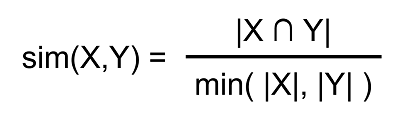

In [ ]:
def overlap_coefficient(tokens_X,tokens_Y):
  # your code!

# Example usage:
overlap_coefficient(['like','irn','bru','irn','bru'], ['irn','bru','very','bad'])

In [ ]:
labtest(overlap_coefficient)

Next, we'll do the Sørenson-Dice Coefficient.

**Exercise**: Implement the `sorenson_dice` function using the equation below:

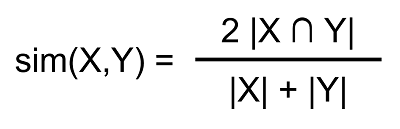

In [ ]:
def sorenson_dice(tokens_X,tokens_Y):
  # your code!

# Example usage:
sorenson_dice(['like','irn','bru','irn','bru'], ['irn','bru','very','bad'])

In [ ]:
labtest(sorenson_dice)

We'll do one more: Jaccard Similarity.

**Exercise:** Implement the `jaccard_similarity` function using the equation below

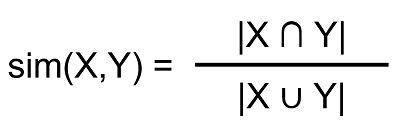

In [ ]:
def jaccard_similarity(tokens_X,tokens_Y):
  # your code!

# Example usage:
jaccard_similarity(['like','irn','bru','irn','bru'], ['irn','bru','very','bad'])

In [ ]:
labtest(jaccard_similarity)

Great. Now we can use a measure to compare our original target post and the two options. Let's use `jaccard_similarity`.

In [ ]:
jaccard_similarity(target_post['tokens'], option_a['tokens'])

In [ ]:
jaccard_similarity(target_post['tokens'], option_b['tokens'])

Option A wins!

However, the similarity scores are fairly low. It looks like there are too many other words that don't overlap between these documents. Maybe there are some documents that provide a higher score.

The code below calculates the similarity scores using `jaccard_similarity` for all posts against our `target_post`.

In [ ]:
scores_with_posts = []
for post in posts:
  similarity_score = jaccard_similarity(target_post['tokens'], post['tokens'])
  scores_with_posts.append( (similarity_score, post))

We then need to sort the posts. We want them in descending order, so use `reverse=True`. We also want to sort by the score only, so give `key=lambda x:x[0]`, which tells it to extract the first element from each tuple (the similarity_score) and use that for sorting. If we didn't do that, it would try to sort the posts, which are dictionaries, and you can't directly sort dictionaries.

In [ ]:
sorted_scores_with_posts = sorted(scores_with_posts, reverse=True, key=lambda x:x[0])

We'll print out the top 10 closest posts below.

In [ ]:
for score,post in sorted_scores_with_posts[:10]:
  print(f"{score:.2f}\t{post['title']}")

The closest post is the target post itself (which is always a good sanity check). Then there are some other posts about drinks. This looks pretty good. The dataset also contains posts on video games and other topics, and they don't appear. So it's broadly working!

It's good to think about the strengths and weaknesses of this set-based approach. There are much more complicated methods for document similarity, so these methods are more straightforward. But they also ignore important things like word frequencies and word importance.

## Wrap Up

Here are some final **open questions** to think about. **There are no definitive answers to these**

1. What extra steps could you add to this set-based approach to improve the similarity scores?
2. How could you measure which similarity measure works best for this set of documents?

**Please submit your lab through Moodle. We don't mark the labs but it helps us to craft better labs in the future**



## Optional Extras

Below is an entirely optional extra idea if you want to dig into a topic more deeply.

**Regular Expressions for Stemming:** Instead of using `if` statements and some manual text manipulation to define the rules for stemming, you could implement them using regular expressions. You would likely want to use the [re.sub](https://docs.python.org/3/library/re.html#re.sub) function. Can you define a function `stem_with_regex` that implements the same rules as `stem_morerules` but with a set of regular expressions? Or one regular expression?